In [1]:
import platform
import os
import math
import pickle
import numpy as np
import matplotlib.pyplot as plt
import mmh3
import random

from BasicFunc import gen_rand_seed, gen_hash, SpreadCollection, actual_relative_error
from BasicFunc import is_valid_ipv4_address, ip_addr_to_int

In [2]:
class vhll():

    def __init__(self, num_phy_registers, num_registers_for_vhll):
        self.num_phy_registers = num_phy_registers
        self.num_registers_for_vhll = num_registers_for_vhll

        distinct_seeds = set()
        while len(distinct_seeds) < num_registers_for_vhll:
            seed_t = gen_rand_seed()
            if seed_t not in distinct_seeds:
                distinct_seeds.add(seed_t)
        self.seeds = list(distinct_seeds)
        self.range_for_seed_index = math.floor(math.log(self.num_registers_for_vhll, 2))
        self.hash_seed = gen_rand_seed()

        self.phy_registers = [0 for i in range(num_phy_registers)]
        self.flows = set()

        self.spread_of_all_flows = 0
        self.alpha = 0
        if self.num_registers_for_vhll == 16:
            self.alpha = 0.673
        elif self.num_registers_for_vhll == 32:
            self.alpha = 0.697
        elif self.num_registers_for_vhll == 64:
            self.alpha = 0.709
        else:
            self.alpha = (0.7213 / (1 + (1.079 / self.num_registers_for_vhll)))

    def set(self, flow_id, ele_id):
        self.flows.add(flow_id)

        ele_hash_value = gen_hash(ele_id, self.hash_seed)
        p_part = ele_hash_value >> (32 - self.range_for_seed_index)
        q_part = ele_hash_value - (p_part << (32 - self.range_for_seed_index))

        leftmost_index = 0
        while q_part:
            leftmost_index += 1
            q_part >>= 1
        leftmost_index = 32 - self.range_for_seed_index - leftmost_index + 1

        index_for_register = gen_hash(flow_id ^ self.seeds[p_part], self.hash_seed) % self.num_phy_registers
        self.phy_registers[index_for_register] = max(self.phy_registers[index_for_register], leftmost_index)

    def update_para(self):
        fraction_zeros = 0
        sum_registers = 0
        for register in self.phy_registers:
            sum_registers += 2 ** (-register)
            if register == 0:
                fraction_zeros += 1
        fraction_zeros = fraction_zeros / self.num_phy_registers
        spread_of_all_flows = (0.7213 / (1 + (1.079 / self.num_phy_registers))) * (
                    self.num_phy_registers ** 2) / sum_registers
        if spread_of_all_flows < 2.5 * self.num_phy_registers:
            if fraction_zeros != 0:
                self.spread_of_all_flows = - self.num_phy_registers * math.log(fraction_zeros)
        elif spread_of_all_flows > 2 ** 32 / 30:
            self.spread_of_all_flows = - 2 ** 32 * math.log(1 - spread_of_all_flows / 2 ** 32)

    def estimate(self, flow_id):
        fraction_zeros_for_vhll = 0
        sum_registers_for_vhll = 0
        for seed in self.seeds:
            index_for_vhll = gen_hash(flow_id ^ seed, self.hash_seed) % self.num_phy_registers
            sum_registers_for_vhll += 2 ** (- self.phy_registers[index_for_vhll])
            if self.phy_registers[index_for_vhll] == 0:
                fraction_zeros_for_vhll += 1
        fraction_zeros_for_vhll = fraction_zeros_for_vhll / self.num_registers_for_vhll
        spread_of_the_flow = self.alpha * (self.num_registers_for_vhll ** 2) / sum_registers_for_vhll

        if spread_of_the_flow < 2.5 * self.num_registers_for_vhll:
            if fraction_zeros_for_vhll != 0:
                spread_of_the_flow = - self.num_registers_for_vhll * math.log(fraction_zeros_for_vhll) - \
                                 (self.num_registers_for_vhll * self.spread_of_all_flows / self.num_phy_registers)
            else:
                spread_of_the_flow = spread_of_the_flow - \
                                     (self.num_registers_for_vhll * self.spread_of_all_flows / self.num_phy_registers)
        elif spread_of_the_flow > 2 ** 32 / 30:
            spread_of_the_flow = - 2 ** 32 * math.log(1 - spread_of_the_flow / 2 ** 32) - \
                                 (self.num_registers_for_vhll * self.spread_of_all_flows / self.num_phy_registers)
        else:
            spread_of_the_flow = spread_of_the_flow - \
                                 (self.num_registers_for_vhll * self.spread_of_all_flows / self.num_phy_registers)

        return spread_of_the_flow

    def get_all_spread(self):
        self.update_para()
        all_spread = {}
        for flow_id in self.flows:
            all_spread[flow_id] = self.estimate(flow_id)
            # print(all_spread[flow_id])
        return all_spread

In [3]:
fo = open("04.txt", "r")
flows = fo.readlines()
fo.close()

In [4]:
num_registers_for_vhll = 64
num_phy_registers = int(0.25 * 2 ** 23 / 5)
vhll_instance = vhll(num_phy_registers, num_registers_for_vhll)

In [5]:
num_bits_for_register = math.ceil(math.log(32 - math.log(num_registers_for_vhll, 2), 2))

In [6]:
sss1 = 12
sss2 = 21

for item in flows:
    e, f = item.strip().split()
    f = mmh3.hash(f, sss1)
    e = mmh3.hash(e, sss2)
    vhll_instance.set(f, e)

In [7]:
estimation = vhll_instance.get_all_spread()

In [8]:
import collections

flows_info = collections.defaultdict(list)

for item in flows:
    e, f = item.strip().split()
    flows_info[f].append(e)

In [9]:
spread_info = dict()

for f in flows_info.keys():
    spread_info[f] = len(set(flows_info[f]))

In [15]:
x = list()
y = list()

for f in flows_info.keys():
    x.append(spread_info[f])
    y.append(estimation[mmh3.hash(f, sss1)])

x = np.array(x)
y = np.maximum(1, np.array(y))

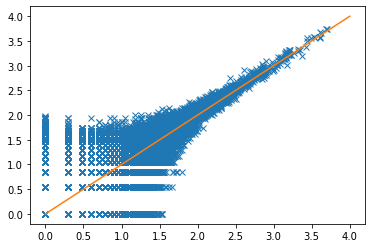

In [17]:
x1 = range(0, 5)
y1 = x1

plt.plot(np.log10(x), np.log10(y), "x")
plt.plot(x1, y1)
plt.show()

In [18]:
ARE_lst = [[] for i in range(4)]

for i in range(len(x)):
    ARE_lst[int(np.log10(x[i]))].append(abs(x[i]-y[i])/x[i])
    
print([np.mean(lst) for lst in ARE_lst])

[5.062082825881563, 0.5923838162880419, 0.17804580905384407, 0.1312042681148335]


In [21]:
np.mean(abs((x-y)/x))

4.74604622190265

In [22]:
np.mean(abs(x-y))

6.708213415307319

In [23]:
len(x)

161047

In [24]:
data = list()

for i in range(len(x)):
    data.append(str(x[i]) + " " + str(y[i]) + "\n")
    
data = list(set(data))
print(len(data))

3034


In [25]:
fo = open("vHLL256KB.data", "w")
fo.writelines(data)
fo.close()